# **Importación de Librerías**

In [28]:
%load_ext autoreload
%autoreload 2

import json
import mlflow
import mlflow.exceptions
import optuna
import os
import pprint
import tempfile
import time
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset

from optuna.visualization import plot_pareto_front, plot_param_importances

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

from utils.load_data import *
from utils.train_predict import train_validate_loop, predict
from utils.early_stopping import EarlyStopping
from utils.metrics import *
from utils.optuna_utils import *

from models.lstm import *

from tqdm.notebook import tqdm

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
OPTUNA_STORAGE = "sqlite:///optuna_db.sqlite3"

HOST = "0.0.0.0"
PORT = 8080
TRACKING_SERVER_URI = f"http://{HOST}:{PORT}"
mlflow.set_tracking_uri(TRACKING_SERVER_URI)

In [3]:
EXPERIMENT_NAME = "Final Project - CS - FAMAF - 2024"
EXPERIMENT_DESCRIPTION = (
    "Final Project of Computer Science MS at FAMAF-UNC: Control Group Identification "
    "with Neural Networks"
)
EXPERIMENT_TAGS = {
    "project_name": "FinalProject-CS-FAMAF-2024",
    "author": "bbas",
    "mlflow.note.content": EXPERIMENT_DESCRIPTION
}

try:
    mlflow.create_experiment(name=EXPERIMENT_NAME, tags=EXPERIMENT_TAGS)
except mlflow.exceptions.RestException as e:
    print(e)
mlflow.set_experiment(EXPERIMENT_NAME)

RESOURCE_ALREADY_EXISTS: Experiment 'Final Project - CS - FAMAF - 2024' already exists.


<Experiment: artifact_location='mlflow-artifacts:/141862488478819453', creation_time=1733267099194, experiment_id='141862488478819453', last_update_time=1733267099194, lifecycle_stage='active', name='Final Project - CS - FAMAF - 2024', tags={'author': 'bbas',
 'mlflow.note.content': 'Final Project of Computer Science MS at FAMAF-UNC: '
                        'Control Group Identification with Neural Networks',
 'project_name': 'FinalProject-CS-FAMAF-2024'}>

In [4]:
DATA_DIR = "/users/bbas/TrabajoFinal/databases"
GROUP = "Grupo1"
SIMULATION = "Simulacion_1.dta"
FILEPATH = os.path.join(DATA_DIR, GROUP, SIMULATION)

def start_new_run():
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    run = mlflow.start_run(run_name=f"run_{timestamp}")
    mlflow.log_params({
        "Group": GROUP,
        "Simulation": SIMULATION,
        "Filepath": FILEPATH,
    })
    return run

active_run = mlflow.active_run()
if not active_run:
    run = start_new_run()
else:
    print(f"There is an active run, name: {active_run.info.run_name}")
    end_run = input("Do you want to delete it? (y/n): ")
    if end_run == "y":
        mlflow.end_run()
        run = start_new_run()
    else:
        run = active_run

**Terminología**:
* Tipo 1: individuos tratados.
* Tipo 2: individuos de control (i.e. podrían haber sido tratados pero por alguna razón no lo fueron)
* Tipo 3: ni tratados ni de control.

In [5]:
type1_df, type2_df, type3_df = get_dfs(FILEPATH)

for i, df in enumerate([type1_df, type2_df, type3_df]):
    with tempfile.TemporaryDirectory() as tmpdir:
        file_path = os.path.join(tmpdir, f"type{i+1}.csv")
        df.to_csv(file_path, index=False)
        mlflow.log_artifact(file_path, artifact_path="dataframes")

# **Conjunto de entrenamiento**
En el conjunto de entrenamiento, metemos:
* Todos los de tipo 1 (con target 1)
* Algunos de tipo 3 (con target 0).


In [6]:
# De los individuos de tipo 3, vamos a meter 600 en el conjunto de entrenamiento
# de forma tal de tener en total 700 (600 + 100, 70%) individuos en en este conjunto.
type3_train = 600
# A los que sobran los metemos en el de test
type3_test  = len(type3_df) - type3_train

In [7]:
train_df = pd.concat([type1_df, type3_df[:type3_train]], ignore_index=True)
train_df.set_index('id', inplace=True)

X_train_df = train_df.drop(columns=['tratado', 'control'])
y_train_df = train_df['tratado']

## **Balanceo de clases**

In [8]:
y_train_df.value_counts()

tratado
0    600
1    100
Name: count, dtype: int64

Vemos que el conjunto de entrenamiento está desbalanceado: tiene 100 datos con label 1 y 600 con label 0. Vamos a dejar el dataset así y corregirlo asignando pesos a la función de pérdida durante el entrenamiento. Calculo los pesos acá:

In [9]:
weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_df), y=y_train_df
)

print(f"Peso para la clase 0 (mayoritaria): {weights[0]:.4f}")
print(f"Peso para la clase 1 (minoritaria): {weights[1]:.4f}")

Peso para la clase 0 (mayoritaria): 0.5833
Peso para la clase 1 (minoritaria): 3.5000


# **Conjunto de validación**
TODO!!!!

Para la búsqueda de hiperparámetros con Optuna.

Hasta ahora, nos quedan:
- Todos los individuos de tipo 2, que son 100
- 200 inidivudos de tipo 3

Vamos a hacer un split de 70-20-10. O sea, si en total tenemos 1000 muestras, en el de validación tenemos que dejar 200 y en el de test 100.

Primera alternativa:
- Validación:
- Test: 

# **Conjunto de test**
En el conjunto de test, metemos:
* Todos los de tipo 2 (con target 1)
* Los que sobraron de tipo 3 (con target 0).

In [10]:
test_df = pd.concat([type2_df, type3_df[type3_train:]], ignore_index=True)
test_df.set_index('id', inplace=True)

X_test_df = test_df.drop(columns=['tratado', 'control'])
y_test_df = test_df['control']

Estandarizamos:

In [11]:
required_periods = 4
mlflow.log_param("required_periods", required_periods)

value_columns = ['inicio_prog'] + [f'y(t-{i})' for i in range(required_periods, 0, -1)]

In [12]:
scaler =  StandardScaler().fit(X_train_df[value_columns])

X_train_df[value_columns] = scaler.transform(X_train_df[value_columns])
train_df[value_columns] = X_train_df[value_columns]

X_test_df[value_columns] = scaler.transform(X_test_df [value_columns])
test_df[value_columns] = X_test_df [value_columns]

In [13]:
mlflow.log_input(
    mlflow.data.from_pandas(test_df, targets="control"),
    context="testing",
)
mlflow.log_input(
    mlflow.data.from_pandas(train_df, targets="tratado"),
    context="training",
)

/users/bbas/.pyenv/versions/TrabajoFinal/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/users/bbas/.pyenv/versions/TrabajoFinal/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values.

# **LSTM**

Basados en el documento `docs/lstm.md`, transformemos los datos que tenemos a la forma que necesitan las LSTM:
`(batch_size, sequence_length, num_features)`.

Cada fila es un individuo y en cada fila ya tenemos todo lo que necesitamos, los 4 datos temporales (`y(t-4)`, `y(t-3)`, `y(t-2)`, `y(t-1)`) y además el dato estático (`inicio_prog`) que lo vamos a tener que repetir cuatro veces para tener la dimensión que deseamos.

In [14]:
time_steps = required_periods
num_features = 2

In [15]:
X_train_tensor = get_lstm_input(X_train_df, time_steps, num_features)
X_test_tensor  = get_lstm_input(X_test_df , time_steps, num_features)

# When using BCEWithLogitsLoss as loss function, the targets should be casted to
# float
y_train_tensor = torch.tensor(y_train_df.values, dtype=torch.float)
y_test_tensor  = torch.tensor(y_test_df.values , dtype=torch.float)

train_set = TensorDataset(X_train_tensor, y_train_tensor)
test_set  = TensorDataset(X_test_tensor , y_test_tensor)

## **Búsqueda de hiperparámetros con Optuna**

In [16]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
study_name = f"study_{timestamp}"
study_n_trials = 10

metrics = ["accuracy", "avg_feats_diff"]
directions = ["maximize", "minimize"]
kwargs = {}

mlflow.log_params({
    "study_name": study_name,
    "study_n_trials": study_n_trials,
    "objective_metrics": metrics,
    "directions": directions
})

study = optuna.create_study(
    directions=directions,
    storage=OPTUNA_STORAGE,
    study_name=study_name
)
study.set_metric_names(metrics)
study.optimize(
    lambda trial: objective(trial, train_set, test_set, weights, metrics, **kwargs),
    n_trials=study_n_trials,
    timeout=600,
    n_jobs=-1,
    show_progress_bar=True
)

[I 2024-12-09 23:18:38,572] A new study created in RDB with name: study_20241209-231837
/tmp/ipykernel_3507131/511361121.py:21: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(metrics)


  0%|          | 0/10 [00:00<?, ?it/s]

/users/bbas/.pyenv/versions/TrabajoFinal/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


[I 2024-12-09 23:19:17,129] Trial 8 finished with values: {'accuracy': 0.7633333333333333, 'avg_feats_diff': 2.403488874435425} and parameters: {'hidden_size': 51, 'n_layers': 1, 'optimizer': 'Adam', 'lr': 0.0006301093129217892, 'n_epochs': 132, 'batch_size': 79}.
[I 2024-12-09 23:19:43,027] Trial 6 finished with values: {'accuracy': 0.84, 'avg_feats_diff': 0.6849752068519592} and parameters: {'hidden_size': 45, 'n_layers': 3, 'optimizer': 'RMSprop', 'lr': 0.021613519800642512, 'n_epochs': 200, 'batch_size': 121}.
[I 2024-12-09 23:19:52,860] Trial 5 finished with values: {'accuracy': 0.7633333333333333, 'avg_feats_diff': 4.393928527832031} and parameters: {'hidden_size': 47, 'n_layers': 2, 'optimizer': 'RMSprop', 'lr': 1.3841076968999591e-05, 'n_epochs': 180, 'batch_size': 57}.
[I 2024-12-09 23:20:00,180] Trial 9 finished with values: {'accuracy': 0.9066666666666666, 'avg_feats_diff': 0.25565195083618164} and parameters: {'hidden_size': 89, 'n_layers': 2, 'optimizer': 'RMSprop', 'lr': 

In [ ]:
fig = plot_pareto_front(study, target_names=metrics)

with tempfile.TemporaryDirectory() as tmpdir:
    file_path = os.path.join(tmpdir, "pareto_front_plot.png")
    fig.write_image(file_path)
    mlflow.log_artifact(file_path)

In [18]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

for i, (metric, direction) in enumerate(zip(metrics, directions)):
    if direction == 'maximize':
        best_trial = max(study.best_trials, key=lambda t: t.values[i])
    elif direction == 'minimize':
        best_trial = min(study.best_trials, key=lambda t: t.values[i])
    
    print(f"Metric: {metric}")
    print(f"\tDirection: {direction}")
    print(f"\tTrial number: {best_trial.number}")
    print(f"\tValues: {best_trial.values}")
    print(f"\tParams: {best_trial.params}")

Number of trials on the Pareto front: 2
Metric: accuracy
	Direction: maximize
	Trial number: 9
	Values: [0.9066666666666666, 0.25565195083618164]
	Params: {'hidden_size': 89, 'n_layers': 2, 'optimizer': 'RMSprop', 'lr': 0.002355414378793765, 'n_epochs': 242, 'batch_size': 82}
Metric: avg_feats_diff
	Direction: minimize
	Trial number: 7
	Values: [0.8233333333333334, 0.08077871799468994]
	Params: {'hidden_size': 25, 'n_layers': 3, 'optimizer': 'Adam', 'lr': 0.01229498979348333, 'n_epochs': 153, 'batch_size': 30}


In [ ]:
best_trials_info = get_best_trials_info(study, metrics)
with tempfile.TemporaryDirectory() as tmpdir:
    file_path = os.path.join(tmpdir, "best_trials_info.json")
    with open(file_path, "w") as f:
        json.dump(best_trials_info, f)
    mlflow.log_artifact(file_path)

In [20]:
best_trials_numbers = [trial['trial_number'] for trial in best_trials_info]
mlflow.log_params({
    "best_trials_numbers": best_trials_numbers
})

## **Entrenamiento del modelo con mejores hiperparámetros**

In [31]:
trial_number = best_trials_numbers[0]

params = study.trials[trial_number].params
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hidden_size = params['hidden_size']
n_layers = params['n_layers']
model = LSTMClassifier(num_features, hidden_size, 1, n_layers).to(device)

lr = params['lr']
optimizer_name = params['optimizer']
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

batch_size = params['batch_size']
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

X_test_tensor = test_set.tensors[0].to(device)

if 'avg_feats_diff' in metrics:
    train_features_mean = get_features_mean(X_train_tensor, y_train_tensor).to(device)

loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(weights[1], dtype=torch.float32)
)

epochs = params['n_epochs']

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch} -----------------------------------------------------")
    train_step(model, train_loader, loss_fn, optimizer)
    
    logits = model(X_test_tensor)
    y_valid_pred = predict(logits, loss_fn).squeeze()

    metrics_kwargs = {}
    if 'avg_feats_diff' in metrics:
        metrics_kwargs['X_valid'] = X_test_tensor
        metrics_kwargs['train_features_mean'] = train_features_mean
    if 'f_beta_score' in metrics:
        metrics_kwargs['beta'] = kwargs['beta']
    metrics_values = compute_metrics(metrics, y_test_tensor, y_valid_pred, **metrics_kwargs)
    print(metrics_values)

    mlflow.log_metrics(metrics_values)

  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 0 -----------------------------------------------------
{'accuracy': 0.75, 'avg_feats_diff': 1.9698553085327148}
Epoch 1 -----------------------------------------------------
{'accuracy': 0.7566666666666667, 'avg_feats_diff': 1.9325406551361084}
Epoch 2 -----------------------------------------------------
{'accuracy': 0.7633333333333333, 'avg_feats_diff': 2.616727352142334}
Epoch 3 -----------------------------------------------------
{'accuracy': 0.76, 'avg_feats_diff': 2.1702187061309814}
Epoch 4 -----------------------------------------------------
{'accuracy': 0.7533333333333333, 'avg_feats_diff': 1.9730031490325928}
Epoch 5 -----------------------------------------------------
{'accuracy': 0.7666666666666667, 'avg_feats_diff': 2.434504270553589}
Epoch 6 -----------------------------------------------------
{'accuracy': 0.78, 'avg_feats_diff': 2.4179537296295166}
Epoch 7 -----------------------------------------------------
{'accuracy': 0.77, 'avg_feats_diff': 2.618016004562

In [34]:
model.to('cpu')

y_test_pred = model(X_test_tensor)
y_test_pred = predict(y_test_pred, loss_fn).squeeze()

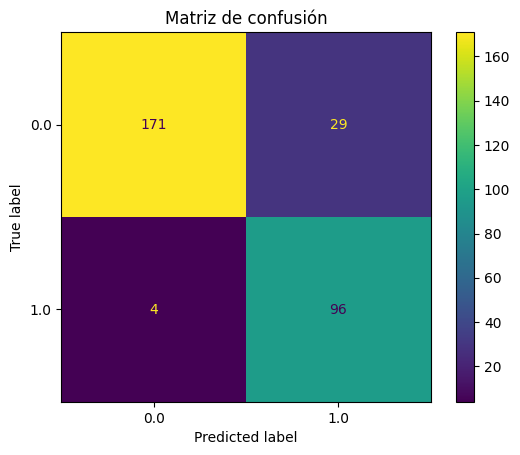

In [37]:
fig = confusion_matrix_plot(y_test_tensor, y_test_pred)

with tempfile.TemporaryDirectory() as tmpdir:
    file_path = os.path.join(tmpdir, "confusion_matrix_plot.png")
    fig.savefig(file_path)
    mlflow.log_artifact(file_path)

fig.show()